In [1]:
# Upload your zip file
from google.colab import files
uploaded = files.upload()

import zipfile
import os

# Using zipfile to receive the zipped folder of images and unzip it
zip_path = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/corals_dataset')

# Check the folder structure
os.listdir('/content/corals_dataset/corals')

Saving corals.zip to corals.zip


['bleached_corals', 'healthy_corals']

In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Set path to the dataset
dataset_dir = '/content/corals_dataset/corals'

In [3]:
# Dataset details
import os

dataset_dir = '/content/corals_dataset/corals'  # Unzipped dataset path

bleached_dir = os.path.join(dataset_dir, 'bleached_corals')
healthy_dir = os.path.join(dataset_dir, 'healthy_corals')

num_bleached = len(os.listdir(bleached_dir))
num_healthy = len(os.listdir(healthy_dir))

print(f"Number of bleached coral images: {num_bleached}")
print(f"Number of healthy coral images: {num_healthy}")


Number of bleached coral images: 485
Number of healthy coral images: 438


In [4]:
# RESNET MODEL
# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Dataset path
dataset_dir = '/content/corals_dataset/corals'
bleached_dir = os.path.join(dataset_dir, 'bleached_corals')
healthy_dir = os.path.join(dataset_dir, 'healthy_corals')

print(f"Bleached coral images: {len(os.listdir(bleached_dir))}")
print(f"Healthy coral images: {len(os.listdir(healthy_dir))}")

Bleached coral images: 485
Healthy coral images: 438


In [6]:
# Data generators with augmentation
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)


train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 739 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


In [7]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Smaller LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size + 1,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size + 1,
    epochs=50
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 214s 8s/step - accuracy: 0.5803 - loss: 0.7720 - val_accuracy: 0.6685 - val_loss: 0.6618
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 193s 8s/step - accuracy: 0.7316 - loss: 0.5331 - val_accuracy: 0.7391 - val_loss: 0.5685
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 200s 8s/step - accuracy: 0.7634 - loss: 0.4911 - val_accuracy: 0.7663 - val_loss: 0.5761
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step - accuracy: 0.8608 - loss: 0.3230 - val_accuracy: 0.7772 - val_loss: 0.7188
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - accuracy: 0.9002 - loss: 0.2708 - val_accuracy: 0.7391 - val_loss: 0.7313
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 192s 8s/step - accuracy: 0.9005 - loss: 0.2391 - val_accuracy: 0.7880 - val_loss: 0.8292
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 202s 8s/step - accuracy: 0.9011 - loss: 0.2244 - val_accuracy: 0.7446 - val_loss: 1.0676
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 190s 8s/step - accuracy: 0.9158 - loss: 0.2011 - val_accuracy: 0.7337 - v

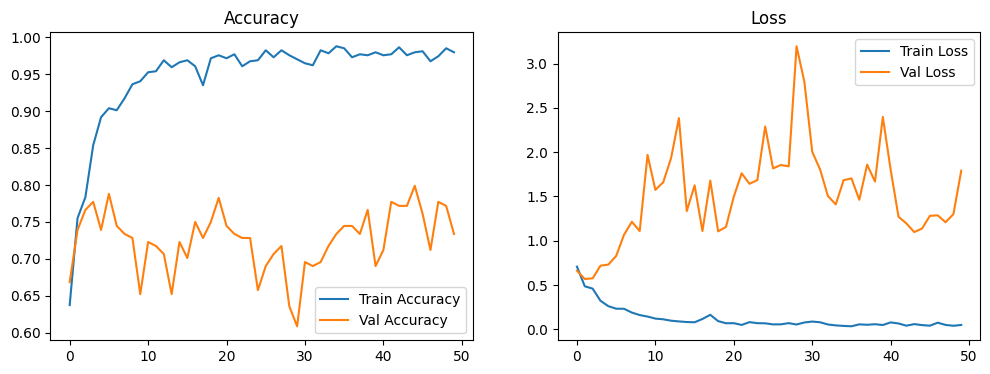

In [8]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [9]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

# Generate confusion matrix & classification report
Y_true = validation_generator.classes
Y_pred_prob = model.predict(validation_generator)
Y_pred = (Y_pred_prob > 0.5).astype(int).reshape(-1)

cm = confusion_matrix(Y_true, Y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(Y_true, Y_pred, target_names=list(validation_generator.class_indices.keys())))

# Save the model (if needed)
# model.save('coral_resnet50_model.h5')

6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.6851 - loss: 2.3321
Validation Accuracy: 73.37%
Validation Loss: 1.7913
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step
Confusion Matrix:
[[58 39]
 [10 77]]

Classification Report:
                 precision    recall  f1-score   support

bleached_corals       0.85      0.60      0.70        97
 healthy_corals       0.66      0.89      0.76        87

       accuracy                           0.73       184
      macro avg       0.76      0.74      0.73       184
   weighted avg       0.76      0.73      0.73       184

